# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
X_train_torch = torch.from_numpy(X_train)
y_train_torch = torch.from_numpy(y_train)
X_val_torch = torch.from_numpy(X_val)
y_val_torch = torch.from_numpy(y_val)
X_test_torch = torch.from_numpy(X_test)
y_test_torch = torch.from_numpy(y_test)
X_dev_torch = torch.from_numpy(X_dev)
y_dev_torch = torch.from_numpy(y_dev)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive, softmax_loss_vectorized, softmax_loss_vectorized_pytorch
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
W_torch = torch.from_numpy(W)
#loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

X_dev_torch = torch.from_numpy(X_dev)
y_dev_torch = torch.from_numpy(y_dev)
loss_torch, grad_torch = softmax_loss_vectorized_pytorch(W_torch, X_dev_torch, y_dev_torch, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f, loss_torch: %f' % (loss, loss_torch))
#print('grad: ', grad[:3])
#print('grad_torch:', grad_torch[:3])
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.373401, loss_torch: 2.373401
grad:  [[-3.53829257  0.60769232  1.24037831  0.59288141  2.45291338  0.8630667
   1.76228598  1.12901581 -1.80722082 -3.30272051]
 [-4.87716391  0.74033305  1.57979438  2.44443982  2.64931701  1.50192784
   2.41282273  1.03148932 -3.40725317 -4.07570708]
 [-6.94798117  0.48989412  3.01908179  3.02184834  4.22908284  1.81245939
   3.86396619  0.90589042 -5.3709082  -5.02333373]]
grad_torch: tensor([[-3.5383,  0.6077,  1.2404,  0.5929,  2.4529,  0.8631,  1.7623,
          1.1290, -1.8072, -3.3027],
        [-4.8772,  0.7403,  1.5798,  2.4444,  2.6493,  1.5019,  2.4128,
          1.0315, -3.4073, -4.0757],
        [-6.9480,  0.4899,  3.0191,  3.0218,  4.2291,  1.8125,  3.8640,
          0.9059, -5.3709, -5.0233]], dtype=torch.float64)
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


func = softmax_loss_vectorized_pytorch
inputs = (W_torch, X_dev_torch, y_dev_torch, 0.0)
# True if all differences satisfy allclose condition
rslt = torch.autograd.gradcheck(func, inputs, eps=1e-6, atol=1e-5, rtol=1e-3, raise_exception=True)
print("正则因子为0时的梯度检验是否通过：", rslt)
# True if all differences satisfy allclose condition
inputs = (W_torch, X_dev_torch, y_dev_torch, 5e1)
rslt = torch.autograd.gradcheck(func, inputs, eps=1e-6, atol=1e-5, rtol=1e-3, raise_exception=True)
print("正则因子为50时的梯度检验是否通过：", rslt)

numerical: 0.723998 analytic: 0.723998, relative error: 2.871068e-08
numerical: -0.365684 analytic: -0.365684, relative error: 2.969105e-08
numerical: -2.261843 analytic: -2.261843, relative error: 2.615373e-09
numerical: 2.354143 analytic: 2.354143, relative error: 7.351527e-09
numerical: -2.548957 analytic: -2.548957, relative error: 9.755043e-09
numerical: -3.527785 analytic: -3.527785, relative error: 1.443750e-08
numerical: 1.667429 analytic: 1.667428, relative error: 2.017936e-08
numerical: 3.457288 analytic: 3.457288, relative error: 1.100901e-08
numerical: -2.236292 analytic: -2.236292, relative error: 1.019708e-08
numerical: -3.168420 analytic: -3.168420, relative error: 2.636487e-10
numerical: -4.167540 analytic: -4.167540, relative error: 2.173080e-08
numerical: 0.693553 analytic: 0.693553, relative error: 6.961679e-08
numerical: 1.401829 analytic: 1.401829, relative error: 4.377312e-08
numerical: -3.335468 analytic: -3.335468, relative error: 4.062294e-09
numerical: -3.4132

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.373401e+00 computed in 0.214471s
vectorized loss: 2.373401e+00 computed in 0.015420s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
# 使用验证集来调整超参(正则化强度和学习率)。你应该尝试不同的学习率和正则强度
# 如果你小心你应该能够在验证集上获得超过0.35的分类准确度
from cs231n.classifiers import Softmax, Softmax_pytorch
results = {}
best_val = -1
best_softmax = None
learning_rates = [4.9e-7, 5e-7, 5.1e-7]
regularization_strengths = [1.4e4, 1.5e4, 1.6e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        sm = Softmax()
        sm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=2000)
        train_pred = sm.predict(X_train)
        train_accuracy = np.mean(train_pred == y_train).item()
        val_pred = sm.predict(X_val)
        val_accuracy = np.mean(val_pred == y_val)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = sm
        
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 4.900000e-07 reg 1.400000e+04 train accuracy: 0.346245 val accuracy: 0.354000
lr 4.900000e-07 reg 1.500000e+04 train accuracy: 0.348490 val accuracy: 0.368000
lr 4.900000e-07 reg 1.600000e+04 train accuracy: 0.340347 val accuracy: 0.344000
lr 5.000000e-07 reg 1.400000e+04 train accuracy: 0.342531 val accuracy: 0.355000
lr 5.000000e-07 reg 1.500000e+04 train accuracy: 0.338531 val accuracy: 0.353000
lr 5.000000e-07 reg 1.600000e+04 train accuracy: 0.337408 val accuracy: 0.347000
lr 5.100000e-07 reg 1.400000e+04 train accuracy: 0.342286 val accuracy: 0.360000
lr 5.100000e-07 reg 1.500000e+04 train accuracy: 0.338327 val accuracy: 0.360000
lr 5.100000e-07 reg 1.600000e+04 train accuracy: 0.341102 val accuracy: 0.359000
best validation accuracy achieved during cross-validation: 0.368000


## Pytorch 实现

In [7]:
results = {}
best_val = -1
best_softmax_torch = None
learning_rates = [4.9e-7, 5e-7, 5.1e-7]
regularization_strengths = [1.4e4, 1.5e4, 1.6e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        sm = Softmax_pytorch()
        sm.train(X_train_torch, y_train_torch, learning_rate=lr, reg=reg, num_iters=2000)
        train_pred = sm.predict(X_train_torch)
        train_accuracy = torch.mean((train_pred == y_train_torch).double())
        val_pred = sm.predict(X_val_torch)
        val_accuracy = torch.mean((val_pred == y_val_torch).double())
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax_torch = sm
        
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 4.900000e-07 reg 1.400000e+04 train accuracy: 0.340224 val accuracy: 0.346000
lr 4.900000e-07 reg 1.500000e+04 train accuracy: 0.344612 val accuracy: 0.360000
lr 4.900000e-07 reg 1.600000e+04 train accuracy: 0.338449 val accuracy: 0.344000
lr 5.000000e-07 reg 1.400000e+04 train accuracy: 0.346878 val accuracy: 0.354000
lr 5.000000e-07 reg 1.500000e+04 train accuracy: 0.339898 val accuracy: 0.355000
lr 5.000000e-07 reg 1.600000e+04 train accuracy: 0.342735 val accuracy: 0.344000
lr 5.100000e-07 reg 1.400000e+04 train accuracy: 0.348408 val accuracy: 0.367000
lr 5.100000e-07 reg 1.500000e+04 train accuracy: 0.347102 val accuracy: 0.355000
lr 5.100000e-07 reg 1.600000e+04 train accuracy: 0.342388 val accuracy: 0.357000
best validation accuracy achieved during cross-validation: 0.367000


In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.359000


In [9]:
y_test_pred_torch = best_softmax_torch.predict(X_test_torch)
test_accuracy_torch = torch.mean((y_test == y_test_pred_torch).double())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy_torch, ))

softmax on raw pixels final test set accuracy: 0.349000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

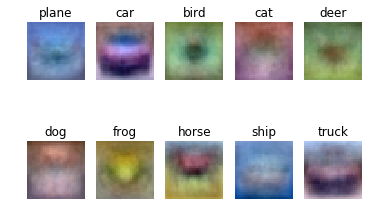

In [10]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## pytorch 实现

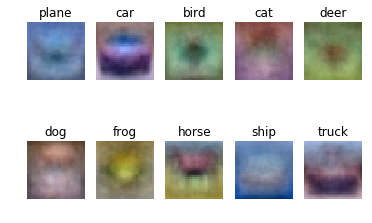

In [11]:
# 可视化每个类的权重
w_torch = best_softmax_torch.W[:-1, :] # 跳过偏置
w_torch = w_torch.reshape(32, 32, 3, 10)
w_min_torch, w_max_torch = torch.min(w_torch), torch.max(w_torch)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    plt.subplot(2, 5, i+1)
    
    # 调整权重到 [0, 255]
    wimg = 255.0 * (w_torch[:, :, :, i] - w_min_torch) / (w_max_torch - w_min_torch)
    plt.imshow(wimg.numpy().astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

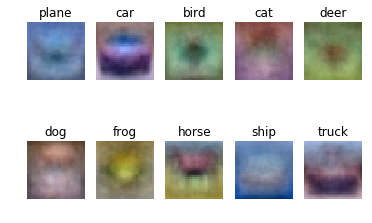

In [34]:
w_torch = best_softmax_torch.W[:-1, :]
w_np = w_torch.reshape(32, 32, 3, 10).numpy()
w_np = w_np.transpose(2, 0, 1, 3)
w_torch = torch.from_numpy(w_np)

# w max-min 规一化
# wimg = (w_torch[:, :, :, i] - w_min_torch) / (w_max_torch - w_min_torch) 
#to_pil_img = torchvision.transforms.ToPILImage()
#plt.imshow(to_pil_img(wimg.float()))

for i in range(10):
    plt.subplot(2, 5, i+1)
    
    # 调整权重到 [0, 255]
    wimg = (w_torch[:, :, :, i] - w_min_torch) / (w_max_torch - w_min_torch)
    plt.imshow(to_pil_img(wimg.float()))
    plt.axis('off')
    plt.title(classes[i])